In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#for each cell line, get PCs of the output of the final layer of the VNN and plot pc1 vs pc2

cell_types_df = pd.read_csv('../data/ccle_maf.txt', sep='\t')
cell_annot_df = pd.read_csv("../data/cell_line_annotations.txt", sep="\t")
cell_annot_map = dict(zip(cell_annot_df.depMapID, cell_annot_df.CCLE_ID))
cell_lines = set(pd.read_csv('../data/cell2ind.txt', sep='\t', header=None, names=['I', 'C'])['C'])
test_file_df = pd.read_csv('../data/5_drugcell_test.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
root_hidden_df = pd.read_csv('../hidden/NEST.hidden', sep=' ', header=None, names=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10'])
root_hidden_df = pd.concat([test_file_df, root_hidden_df], axis=1).reindex(test_file_df.index)

In [4]:
def get_mutated_cell_lines(mut_type_list):
    mut_cell_lines = set()
    ct = cell_types_df[cell_types_df.Hugo_Symbol.isin(mut_type_list)]
    for i,row in ct.iterrows():
        if row['Broad_ID'] in cell_annot_map and cell_annot_map[row['Broad_ID']] in cell_lines:
            mut_cell_lines.add(cell_annot_map[row['Broad_ID']])
    return mut_cell_lines

In [5]:
def get_embedding_plot(pcs, mut_index):
    
    pc1 = pcs[:,0]
    pc2 = pcs[:,1]
    
    pc1 = [i for i in pc1 if i < 6]
    pc2 = [i for i in pc2 if i < 6]

    pc1_color = [pc1[i] for i in mut_index]
    pc2_color = [pc2[i] for i in mut_index]
    pc1_grey = [pc for i, pc in enumerate(pc1) if i not in mut_index]
    pc2_grey = [pc for i, pc in enumerate(pc2) if i not in mut_index]

    fig = plt.figure(figsize = (4, 4))
    ax = fig.add_subplot(111)
    ax.scatter(pc1_grey, pc2_grey, color = 'silver', s = 6)
    ax.scatter(pc1_color, pc2_color, color = 'green', s = 12)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.show()
    return fig

In [10]:
def get_embedding_plot_contigous(pcs, mut_index, score):
    
    pc1 = pcs[:,0]
    pc2 = pcs[:,1]
    
    pc1 = [i for i in pc1 if i < 6]
    pc2 = [i for i in pc2 if i < 6]
    
    pc1_color = [pc1[i] for i in mut_index]
    pc2_color = [pc2[i] for i in mut_index]
    pc1_grey = [pc for i, pc in enumerate(pc1) if i not in mut_index]
    pc2_grey = [pc for i, pc in enumerate(pc2) if i not in mut_index]

    fig = plt.figure(figsize = (4, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.scatter(pc1_grey, pc2_grey, color = 'silver', s = 6)
    points = ax.scatter(pc1_color, pc2_color, c = score, cmap = 'coolwarm', s = 12)
    fig.colorbar(points)
    plt.show()
    return fig

In [15]:
root_hidden_cell_df = root_hidden_df.drop(['D', 'AUC'], 1).drop_duplicates()
hiddens = root_hidden_cell_df.drop('C', 1).iloc[:, :-8].values

scaler = StandardScaler()
scaled_hiddens = scaler.fit_transform(hiddens)

pca = PCA()
root_hidden_pcs = pca.fit_transform(scaled_hiddens)

n = len(root_hidden_pcs[0])
pc_df = pd.DataFrame(root_hidden_pcs[:, :n], index=root_hidden_cell_df.index)
pc_df = pd.concat([root_hidden_cell_df['C'], pc_df], axis=1).reindex(root_hidden_cell_df.index)

n = 211


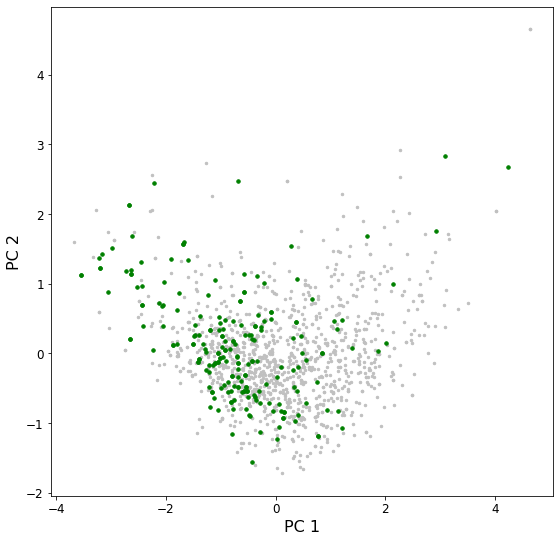

In [16]:
mut_list = ['BRAF']
braf_cell_lines = get_mutated_cell_lines(mut_list)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in braf_cell_lines]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

n = 148


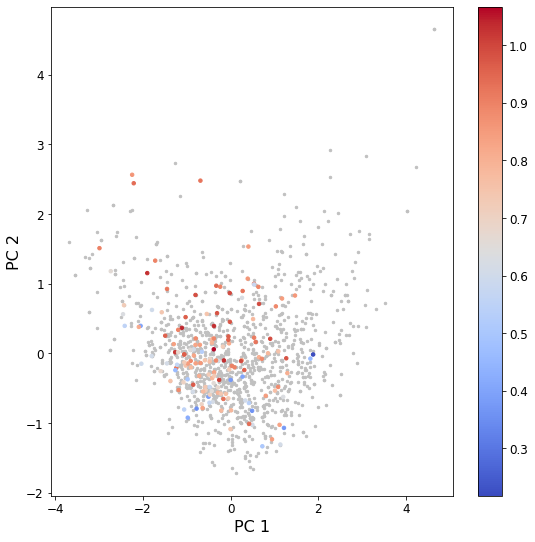

In [17]:
drug = 'CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=O)NOCCO'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)

n = 330


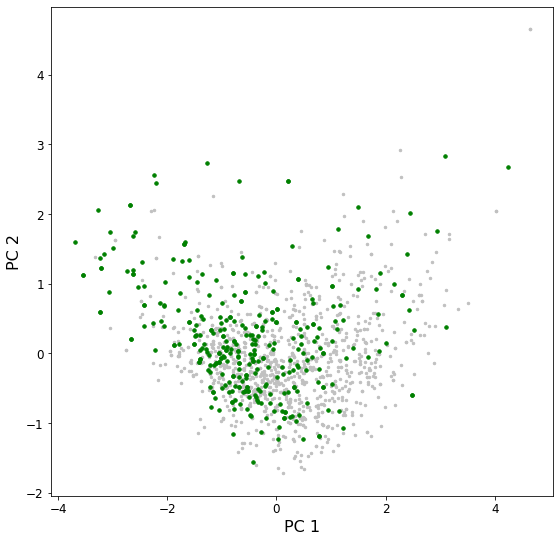

In [18]:
mut_list = ['BRAF', 'EGFR', 'LKB1']
braf_cell_lines = get_mutated_cell_lines(mut_list)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in braf_cell_lines]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

n = 166


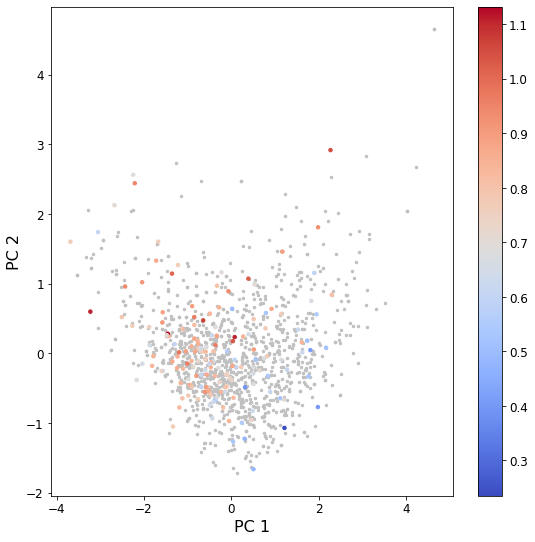

In [19]:
drug = 'CC1=C(SC2=C1C(=N[C@H](C3=NN=C(N32)C)CC(=O)OC(C)(C)C)C4=CC=C(C=C4)Cl)C'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)

n = 158


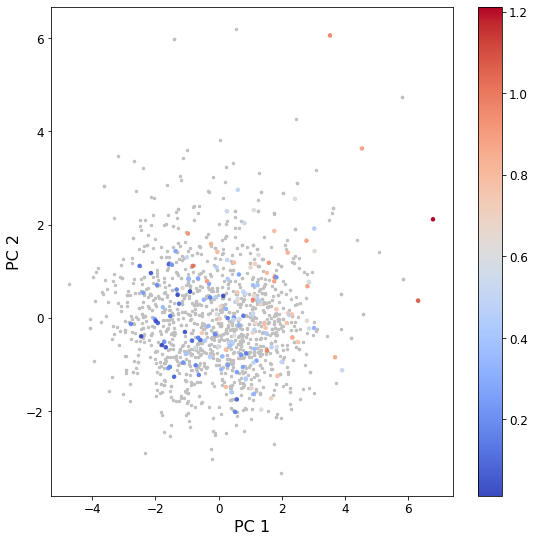

In [14]:
drug = 'CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@](C3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)